In [1]:
import pdb
import argparse
import numpy as np
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torch.autograd import Variable

import seaborn as sns

from models.vgg import VGG
from models.densenet import DenseNet3
from models.wideresnet import WideResNet
from utils.ood_metrics import tpr95, detection
from utils.datasets import GaussianNoise, UniformNoise

## ハイパーパラメータの設定

In [2]:
'''
ind_dataset = cifar10
ood_dataset = tinyImageNet_resize
model = vgg13
process = confidence
'''
batch_size =128
T = 1000.
epsilon = 0.001
filename = 'checkpoints/cifar10_vgg13_budget_0.3_seed_0'
validation = False
cudnn.benchmark = True  # Should make training should go faster for large models

## 正規化の前処理

In [3]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform = transforms.Compose([transforms.ToTensor(), normalize])

## in-distributionはCIFAR10<br>out-of-distributionはImagenet_resize

In [4]:
num_classes = 10
ind_dataset = datasets.CIFAR10(root='data/', train=False, transform=transform, download=True)
ood_dataset = datasets.ImageFolder(root='data/Imagenet_resize', transform=transform)

Files already downloaded and verified


In [5]:
test = datasets.ImageFolder(root='data/Imagenet_resize', transform=transforms.Compose([transforms.ToTensor()]))
img, lab = test[33]

## Imagenet_resizeの画像を見てみる

(-0.5, 31.5, 31.5, -0.5)

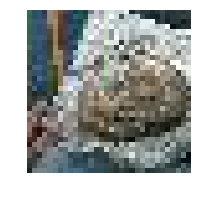

In [6]:
%matplotlib inline

def imshow(img):
    # unnormalize [-1, 1] => [0, 1]
    #img = img / 2 + 0.5
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

plt.figure(figsize=(3,3))
imshow(make_grid(img))
plt.axis('off')

## データローダー

In [7]:
ind_loader = torch.utils.data.DataLoader(
                                         dataset=ind_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=2)

ood_loader = torch.utils.data.DataLoader(
                                         dataset=ood_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=2)

# Use remaining samples for test evaluation
ood_loader.dataset.imgs = ood_loader.dataset.imgs[1000:]
ood_loader.dataset.__len__ = len(ood_loader.dataset.imgs)

## モデルはVGG13＋学習した重みをロード

In [8]:
cnn = VGG(vgg_name='VGG13', num_classes=num_classes).cuda()
model_dict = cnn.state_dict()
pretrained_dict = torch.load(filename + '.pt')
cnn.load_state_dict(pretrained_dict)
cnn = cnn.cuda()
cnn.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

## 評価用の関数

In [9]:
def evaluate(data_loader, mode):
    out = []
    xent = nn.CrossEntropyLoss()
    for data in data_loader:
        if type(data) == list:
            images, labels = data
        else:
            images = data

        images = Variable(images, requires_grad=True).cuda()
        images.retain_grad()

        if mode == 'confidence':
            _, confidence = cnn(images)
            confidence = F.sigmoid(confidence)
            confidence = confidence.data.cpu().numpy()
            out.append(confidence)

        elif mode == 'confidence_scaling':
            epsilon = epsilon.copy()

            cnn.zero_grad()
            _, confidence = cnn(images)
            confidence = F.sigmoid(confidence).view(-1)
            loss = torch.mean(-torch.log(confidence))
            loss.backward()

            images = images - epsilon * torch.sign(images.grad)
            images = Variable(images.data, requires_grad=True)

            _, confidence = cnn(images)
            confidence = F.sigmoid(confidence)
            confidence = confidence.data.cpu().numpy()
            out.append(confidence)

        elif mode == 'baseline':
            # https://arxiv.org/abs/1610.02136
            pred, _ = cnn(images)
            pred = F.softmax(pred, dim=-1)
            pred = torch.max(pred.data, 1)[0]
            pred = pred.cpu().numpy()
            out.append(pred)

        elif mode == 'ODIN':
            # https://arxiv.org/abs/1706.02690
            T = T.copy()
            epsilon = epsilon.copy()

            cnn.zero_grad()
            pred, _ = cnn(images)
            _, pred_idx = torch.max(pred.data, 1)
            labels = Variable(pred_idx)
            pred = pred / T
            loss = xent(pred, labels)
            loss.backward()

            images = images - epsilon * torch.sign(images.grad)
            images = Variable(images.data, requires_grad=True)

            pred, _ = cnn(images)

            pred = pred / T
            pred = F.softmax(pred, dim=-1)
            pred = torch.max(pred.data, 1)[0]
            pred = pred.cpu().numpy()
            out.append(pred)

    out = np.concatenate(out)
    return out

## 両方のデータセットをぶち込む

In [10]:
ind_scores = evaluate(ind_loader, 'confidence')
ind_labels = np.ones(ind_scores.shape[0])

ood_scores = evaluate(ood_loader, 'confidence')
ood_labels = np.zeros(ood_scores.shape[0])

labels = np.concatenate([ind_labels, ood_labels])
scores = np.concatenate([ind_scores, ood_scores])

fpr_at_95_tpr = tpr95(ind_scores, ood_scores)
detection_error, best_delta = detection(ind_scores, ood_scores)
auroc = metrics.roc_auc_score(labels, scores)
aupr_in = metrics.average_precision_score(labels, scores)
aupr_out = metrics.average_precision_score(-1 * labels + 1, 1 - scores)

print("")
print("Method: " + 'confidence')
print("TPR95 (lower is better): ", fpr_at_95_tpr)
print("Detection error (lower is better): ", detection_error)
print("Best threshold:", best_delta)
print("AUROC (higher is better): ", auroc)
print("AUPR_IN (higher is better): ", aupr_in)
print("AUPR_OUT (higher is better): ", aupr_out)

/home/takano/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Method: confidence
TPR95 (lower is better):  0.23696400000000004
Detection error (lower is better):  0.12819999999999998
Best threshold: 0.2200678890842469
AUROC (higher is better):  0.952617835
AUPR_IN (higher is better):  0.9542550603282451
AUPR_OUT (higher is better):  0.9544481907395739


## confidenceの分布

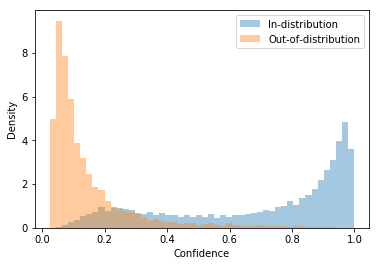

In [11]:
ranges = (np.min(scores), np.max(scores))
plt.figure()
sns.distplot(ind_scores.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='In-distribution')
sns.distplot(ood_scores.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='Out-of-distribution')
plt.xlabel('Confidence')
plt.ylabel('Density')
plt.legend()
plt.show()

## 1枚だけ画像を入力して比較してみる

In [69]:
cifar10_label = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
                             5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

## out-of-distribution用のデータセットは正規化しない

In [96]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
in_transform = transforms.Compose([transforms.ToTensor()])
in_transform.transforms.append(normalize)
in_dataset = datasets.CIFAR10(root='data/', train=False, transform=in_transform, download=True)

out_transform = transforms.Compose([transforms.ToTensor()])
out_dataset = datasets.CIFAR10(root='data/', train=False, transform=out_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


## index33がわかりやすいイッヌなのでこれで試す

In [97]:
in_image, in_label = in_dataset[33]
out_image, out_label = out_dataset[33]

In [98]:
print('type : ', type(in_image), 'in_image : ', in_label, cifar10_label[in_label])
print('type : ', type(out_image), 'out_image : ', out_label, cifar10_label[out_label])

type :  <class 'torch.Tensor'> in_image :  5 dog
type :  <class 'torch.Tensor'> out_image :  5 dog


## out-of-distribution の画像を見てみる<br>in-distribution の画像は-2~2に正規化してあるので表示できない

(-0.5, 31.5, 31.5, -0.5)

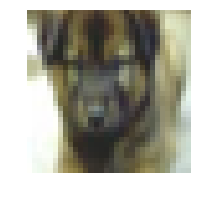

In [99]:
%matplotlib inline

def imshow(img):
    # unnormalize [-1, 1] => [0, 1]
    #img = img / 2 + 0.5
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

plt.figure(figsize=(3,3))
imshow(make_grid(out_image))
plt.axis('off')

## バッチサイズ次元を追加

In [100]:
in_image = torch.unsqueeze(in_image, 0)
out_image = torch.unsqueeze(out_image, 0)

## Varibaleに変換

In [101]:
in_image = Variable(in_image, requires_grad=True).cuda()
#in_image.retain_grad()
out_image = Variable(out_image, requires_grad=True).cuda()
#out_image.retain_grad()

## 順伝播の出力を活性化

In [102]:
in_prediction, in_confidence = cnn(in_image)
in_prediction, in_confidence = F.softmax(in_prediction), F.sigmoid(in_confidence)
out_prediction, out_confidence = cnn(out_image)
out_prediction, out_confidence = F.softmax(out_prediction), F.sigmoid(out_confidence)

/home/takano/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/home/takano/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/takano/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


## in-distribution の画像 → confidence70%!!

In [103]:
in_probability, in_class_num = torch.max(in_prediction, 1)
print('probability : ', in_probability.cpu().detach().numpy())
print('class : ', in_class_num.cpu().detach().numpy(), cifar10_label[in_class_num.cpu().detach().numpy()[0]])
print('confidnece : ', in_confidence.cpu().detach().numpy())

probability :  [0.9987526]
class :  [5] dog
confidnece :  [[0.70243955]]


## out-of-distribution の画像 → confidence9%!!低い!!

In [104]:
out_probability, out_class_num = torch.max(out_prediction, 1)
print('probability : ', out_probability.cpu().detach().numpy())
print('class : ', out_class_num.cpu().detach().numpy(), cifar10_label[out_class_num.cpu().detach().numpy()[0]])
print('confidnece : ', out_confidence.cpu().detach().numpy())

probability :  [0.92188257]
class :  [3] cat
confidnece :  [[0.09652244]]
